In [0]:
import random
import numpy as np
from numpy import asarray
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.models import Sequential
from matplotlib import pyplot



# ****** PLEASE READ *******
# in order to load the dataset you must download these two files
# onto your computer and then upload to this google colab session
# I have shared the two .npy files with you if you wish to download
# each .npy file is about ~250mb in size
# training on these files also takes about hour per training session
# while running on a GPU. So the python notebook is loaded with the output 
# so you don't need to download any files or wait for an hour while you train to
# see results

# loading our data set 
# 8,397 104x104 RGB images in each dataset
# shape (8,397, 104, 104, 3)
street_dataset = np.load('/content/street_dataset_104p.npy')
satellite_dataset = np.load('/content/satellite_dataset_104p.npy')

# building the discriminator
def define_discriminator(in_shape=(104,104,3)):
	model = Sequential()
	# input layer
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer is a binary classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# building the generator
def define_generator(latent_dim):
	model = Sequential()
	# foundation foo 13x13 image
	n_nodes = 256 * 13 * 13
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((13, 13, 256)))
	# upsample to 20x20
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 40x40
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 80x80
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

# building the gan
def define_gan(g_model, d_model):
	# weights in the discriminator are not trainable
	d_model.trainable = False
	# connecting the generator and discriminator
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 
# loading and preparing our data
def load_real_samples():
	trainX = street_dataset
	trainY = satellite_dataset
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	Y = trainY.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	Y = (Y - 127.5) / 127.5

	return X, Y
 
# returns n_samples from the real dataset along with class label of 1 (real)
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
  
	return x_input
 
# returns n_samples of fake generated images along with class label of 0 (fake)
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# creating fake class label 0
	y = zeros((n_samples, 1))
	return X, y
 
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
  # scale from [-1,1] to [0,1]
  examples = (examples + 1) / 2.0
  # plot images
  for i in range(n * n):
    # define subplot
    pyplot.subplot(n, n, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot pixel data
    pyplot.imshow(examples[i])
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    path = '/content/'
    path = path + filename
    pyplot.savefig(path)
    pyplot.close()
 
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy of discriminator on real examples: %.0f%%, fake examples: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	path = '/content/'
	path = path + filename
	g_model.save(path)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=50):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# displaying epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the discriminator performance every 10 epochs, display generated image
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
			vector = asarray([[random.uniform(0, 1) for _ in range(100)]])
			img = g_model.predict(vector)
			img = (img + 1) / 2.0
			pyplot.imshow(img[0, :, :])
			pyplot.show()

In [0]:
# z vector (noise)
latent_dim = 100

# create the discriminator
d_model = define_discriminator()

# create the generator
g_model = define_generator(latent_dim)

# load image data
train_street, train_satellite = load_real_samples()

# create the gan
gan_model = define_gan(g_model, d_model)

# training our model on street dataset
train(g_model, d_model, gan_model, train_street, latent_dim)

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


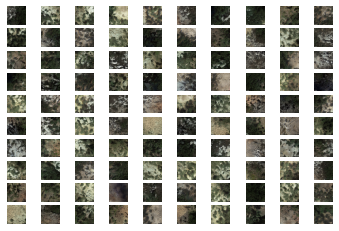

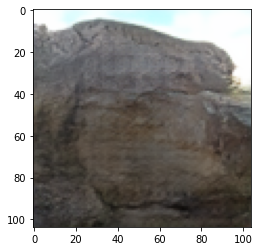

In [0]:
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
import random
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
 
# this cell will display generated images from our generator model that trained
# on the street_dataset_104p.npy file


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()
 
# load model
model = load_model('/content/generator_model_200.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 10)



# load model
model = load_model('/content/street_generator.h5')
# all 0s
vector = asarray([[random.uniform(0, 1) for _ in range(100)]])
# generate image
X = model.predict(vector)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0


# plot the result
pyplot.imshow(X[0, :, :])
pyplot.show()

In [0]:
# this cell trains our model on the satelite_dataset_104p.npy file

# z vector (noise)
latent_dim = 100

# create the discriminator
d_model = define_discriminator()

# create the generator
g_model = define_generator(latent_dim)

# load image data
train_street, train_satellite = load_real_samples()

# create the gan
gan_model = define_gan(g_model, d_model)

# training our model on street dataset
train(g_model, d_model, gan_model, train_satellite, latent_dim)

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


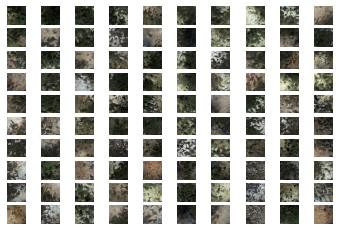

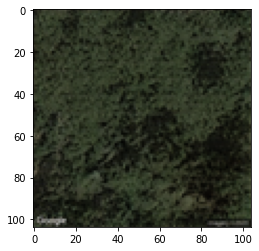

In [0]:
# this cell will display generated images from our generator model that trained
# on the satellite_dataset_104p.npy file


from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
import random
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()
 
# load model
model = load_model('/content/generator_model_200.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 10)



# load model
model = load_model('/content/satellite_generator.h5')
# all 0s
vector = asarray([[random.uniform(0, 1) for _ in range(100)]])
# generate image
X = model.predict(vector)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0


# plot the result
pyplot.imshow(X[0, :, :])
pyplot.show()